Tensorflow Lite is a branch of Tensorflow and aims the inference on the edge or resource-limited devices. In this topic, we start from a SavedModel trained on Tensorflow 2.x and then convert it to a Tensorflow Lite model.

In [14]:
import logging
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.lite as lite

logging.basicConfig(level=logging.INFO, format="%(asctime)s-%(levelname)s:%(message)s")
logging.info("Tensorflow Version: {}".format(tf.__version__))

2020-10-08 17:07:36,422-INFO:Tensorflow Version: 2.2.0


# Tensorflow Model

Here we prepare a Tensorflow model in `SavedModel` format. The model is trained on the MNIST dataset. The source code can refer to the [link](https://github.com/jiankaiwang/aiot/blob/master/tensorrt/trainingMNIST.md).

In [2]:
mnistPath = "/Users/jiankaiwang/Desktop/mnist"
assert os.path.exists(mnistPath)

In [3]:
!saved_model_cli show --all --dir {mnistPath}


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_5'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name: '__call__'
  

# Convertion

The following is a quick start for converting a SavedModel to tflite. You can convert a model in SavedModel format to a Tensorflow Lite model via a built-in tool `tflite_convert`.

## Built-in Command

In [4]:
!tflite_convert -h

usage: tflite_convert [-h] --output_file OUTPUT_FILE
                      [--saved_model_dir SAVED_MODEL_DIR | --keras_model_file KERAS_MODEL_FILE]
                      [--enable_v1_converter]
                      [--experimental_new_converter [EXPERIMENTAL_NEW_CONVERTER]]

Command line tool to run TensorFlow Lite Converter.

optional arguments:
  -h, --help            show this help message and exit
  --output_file OUTPUT_FILE
                        Full filepath of the output file.
  --saved_model_dir SAVED_MODEL_DIR
                        Full path of the directory containing the SavedModel.
  --keras_model_file KERAS_MODEL_FILE
                        Full filepath of HDF5 file containing tf.Keras model.
  --enable_v1_converter
                        Enables the TensorFlow V1 converter in 2.0
  --experimental_new_converter [EXPERIMENTAL_NEW_CONVERTER]
                        Experimental flag, subject to change. Enables MLIR-
                        based conversion instead o

In [5]:
outputPath = "/Users/jiankaiwang/Desktop/mnist_tflite/mnist_savedmodel.tflite"
!tflite_convert --saved_model_dir={mnistPath} --output_file={outputPath}

2020-10-08 17:05:12.332916: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-10-08 17:05:12.372935: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8e9036adc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-08 17:05:12.372960: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-08 17:05:12.678846: I tensorflow/core/grappler/devices.cc:60] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA support)
2020-10-08 17:05:12.678948: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2020-10-08 17:05:12.682887: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:797] Optimization results for grappler item: graph_to_optimize
2020-10-08 17:05:12.682905: I tensorflow/core/grapple

## Quantization

You can further convert the model in an advanced way. e.g. `quantization`, etc. Such a convert can be done through the Tensorflow built-in APIs.

In [6]:
converter = lite.TFLiteConverter.from_saved_model(mnistPath)
converter.optimizations = [lite.Optimize.DEFAULT]
tfliteQuantModel = converter.convert()

outputQuantPath = "/Users/jiankaiwang/Desktop/mnist_tflite/mnist_savedmodel_quant.tflite"
with open(outputQuantPath, "wb") as fout:
  fout.write(tfliteQuantModel)

2020-10-08 17:05:16,189-INFO:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


# Inference

In [7]:
def normalize(imgPath):
  """Normalize the image to the scale in [-1, 1]."""
  _img = tf.io.read_file(imgPath)
  _img = tf.image.decode_jpeg(_img)
  img = tf.cast(_img, tf.float32)
  img = (img - 127.5) / 127.5
  return img, _img

In [8]:
testImgpath = "/Users/jiankaiwang/Desktop/mnist_four.jpg"
img, _img = normalize(testImgpath)
img = tf.expand_dims(img, axis=0)
img.shape

TensorShape([1, 28, 28, 1])

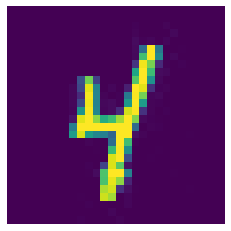

In [9]:
def showImg(img):
  plt.figure()
  plt.imshow(img)
  plt.axis("off")
  plt.show()

showImg(_img)

## Tensorflow

By default, you can load a `tflite` model via the Tensorflow built-in APIs.

In [10]:
model = tf.keras.models.load_model(mnistPath)
model.summary()

preds = model.predict(img)
label = tf.argmax(preds, axis=1)
pred = preds[0][label]
print("Label {} with Prob {:.3f}%".format(label, pred*100))

2020-10-08 17:05:19,686-WARNING:No training configuration found in save file, so the model was *not* compiled. Compile it manually.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256)               533248    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
Label [4] with Prob 99.923%


/Users/jiankaiwang/devops/pyenv/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [16]:
__start = time.time()

# load the TFLite model and allocate tensors
interpreter = lite.Interpreter(model_path=outputPath)
interpreter.allocate_tensors()

# get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details:", input_details, "\noutput_details:", output_details, "\n")

# infer the image
input_shape = input_details[0]['shape']
print("input_shape:", input_shape)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

# get the result
preds = interpreter.get_tensor(output_details[0]['index'])
label = tf.argmax(preds, axis=1)
pred = preds[0][label]
print("Label {} with Prob {:.3f}%".format(label, pred*100))

print("Time Cost: {}".format(time.time() - __start))

input_details: [{'name': 'input_2', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 
output_details: [{'name': 'Identity', 'index': 12, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 

input_shape: [ 1 28 28  1]
Label [4] with Prob 99.923%
Time Cost: 0.0058858394622802734


/Users/jiankaiwang/devops/pyenv/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## TFLite Runtime

If you want to infer the data only without installing the whole Tensorflow package, you can install the tflite runtime only. You can select the suitable package to install tflite runtime from the [link](https://www.tensorflow.org/lite/guide/python). Here we use the one whose label are `macOS 10.14` and `Python 3.7`.

In [ ]:
!pip install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp37-cp37m-macosx_10_14_x86_64.whl

Instead of installing the Tensorflow, you can install the tflite runtime only.

In [1]:
import tflite_runtime.interpreter as tflite

In [4]:
outputPath = "/Users/jiankaiwang/Desktop/mnist_tflite/mnist_savedmodel.tflite"

interpreter = tflite.Interpreter(model_path=outputPath)
interpreter.allocate_tensors()

# get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details:", input_details, "\noutput_details:", output_details, "\n")

# infer the image
# ... the same as the previos section

input_details: [{'name': 'input_2', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}] 
output_details: [{'name': 'Identity', 'index': 12, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}] 



## Inference with a Quantized Model

In [17]:
outputQuantPath = "/Users/jiankaiwang/Desktop/mnist_tflite/mnist_savedmodel_quant.tflite"

__start = time.time()
interpreter = lite.Interpreter(model_path=outputPath)
interpreter.allocate_tensors()

# get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details:", input_details, "\noutput_details:", output_details, "\n")

# infer the image
input_shape = input_details[0]['shape']
print("input_shape:", input_shape)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

# get the result
preds = interpreter.get_tensor(output_details[0]['index'])
label = tf.argmax(preds, axis=1)
pred = preds[0][label]
print("Label {} with Prob {:.3f}%".format(label, pred*100))
print("Time Cost: {}".format(time.time() - __start))

input_details: [{'name': 'input_2', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 
output_details: [{'name': 'Identity', 'index': 12, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] 

input_shape: [ 1 28 28  1]
Label [4] with Prob 99.923%
Time Cost: 0.007762908935546875


/Users/jiankaiwang/devops/pyenv/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
